# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Richard Kocián (xkocia19)_

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile
import re

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [62]:
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        if not re.match(r".*config\d+_run\d\d\d+\.json", filename):
            print(f"'{filename}' neodpovídá přijatelnému názvu, přeskakuji.")
            continue
        with zf.open(filename, "r") as f:
            data.append(json.load(f))

df = pd.DataFrame(data)
df = df.astype({"configuration": str, "run": int, "runtime": float, "status": str})
df

'log_files/' neodpovídá přijatelnému názvu, přeskakuji.


,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

Odlehlé hodnoty pro jednotlivé konfigurace:
                    run      runtime      status
configuration                                   
config1       51     62     0.000000    SEGFAULT
              99    134  1800.000000  TIME LIMIT
              367   184     0.000000    SEGFAULT
              384   113   124.632421     SUCCESS
              758     9  1800.000000  TIME LIMIT
              789   197     0.000000    SEGFAULT
              909   179   127.201692     SUCCESS
              1042   74    73.802549     SUCCESS
              1179  148  1800.000000  TIME LIMIT
              1194  145     0.000000    SEGFAULT
config2       92    142     0.000000    SEGFAULT
              104    40  1800.000000  TIME LIMIT
              608    62    85.174653     SUCCESS
              1075    9   227.054630     SUCCESS
              1113   13  1800.000000  TIME LIMIT
config3       42     41     0.000000    SEGFAULT
              301    78   201.577616     SUCCESS
              318   184  

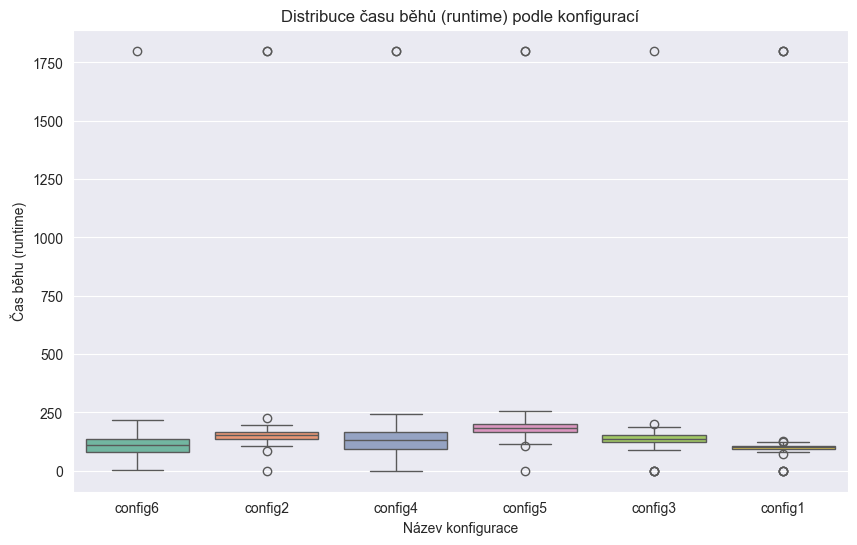

In [63]:
# Detekce odlehlých hodnot pomocí interkvartilového rozpětí (IQR)
def detect_outliers(df):
    Q1 = df["runtime"].quantile(0.25)
    Q3 = df["runtime"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df["runtime"] < lower_bound) | (df["runtime"] > upper_bound)]

outliers = df.groupby("configuration").apply(detect_outliers, include_groups=False)
print("Odlehlé hodnoty pro jednotlivé konfigurace:")
print(outliers)

# Vizualizace pomocí box plotu pro runtime podle konfigurací
plt.figure(figsize=(10, 6))
sns.boxplot(x="configuration", y="runtime", data=df, palette="Set2", hue="configuration")
plt.title("Distribuce času běhů (runtime) podle konfigurací")
plt.xlabel("Název konfigurace")
plt.ylabel("Čas běhu (runtime)")
plt.show()

# plt.figure(figsize=(10, 6))
# sns.boxplot(x="configuration", y="runtime", data=df[df["status"] != "TIME LIMIT"])
# plt.title("Distribuce času běhů (runtime) podle konfigurací pouze se SUCCESS a SEG FAULT")
# plt.xlabel("Název konfigurace")
# plt.ylabel("Čas běhu (runtime)")
# plt.show()
# 
# plt.figure(figsize=(10, 6))
# sns.boxplot(x="configuration", y="runtime", data=df[df["status"] == "SUCCESS"])
# plt.title("Distribuce času běhů (runtime) podle konfigurací pouze se SUCCESS")
# plt.xlabel("Název konfigurace")
# plt.ylabel("Čas běhu (runtime)")
# plt.show()



__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

- Chybné hodnoty jsou tzv. outliers jednotlivých konfigurací. V grafu se jedná o kolečka. Jsou to běhy konfigurací, které jsou buď za vrchní hranicí (qartil Q3 + 1,5 * IQR) nebo pod spodní hranicí (kvartil Q1 - 1,5 * IQR). IQR je Interquartile Range (rozmezí od Q1 (25. percentil) do Q3 (75. percentil))

- Tyto chybné hodnoty zde jsou jednak kvůli tomu, že běhy konfigurací obsahují i běhy se statusem "TIME LIMIT" a běhy se statusem "SEGFAULT". Zároveň i v běhách "SUCCESS" se některé chybné hodnoty nacházejí. Vzhledem k tomu, že se jedná o běhy algoritmů a záleží na hardwarových podmínkách a softwarových, tak při zjišťování dat mohlo dojít k nějakým nenadýlým situacím. Například byl při testovaní spuštěn nějaký další program, který na chvíli odebral nějaké dostupné zdroje.

- Tento typ grafu (boxplots) jsem zvolil, jelikož znázorňuje kvartily jednotlivých běhů, minimum a maximum a zároveň outliers, které budeme vyřazovat.


Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

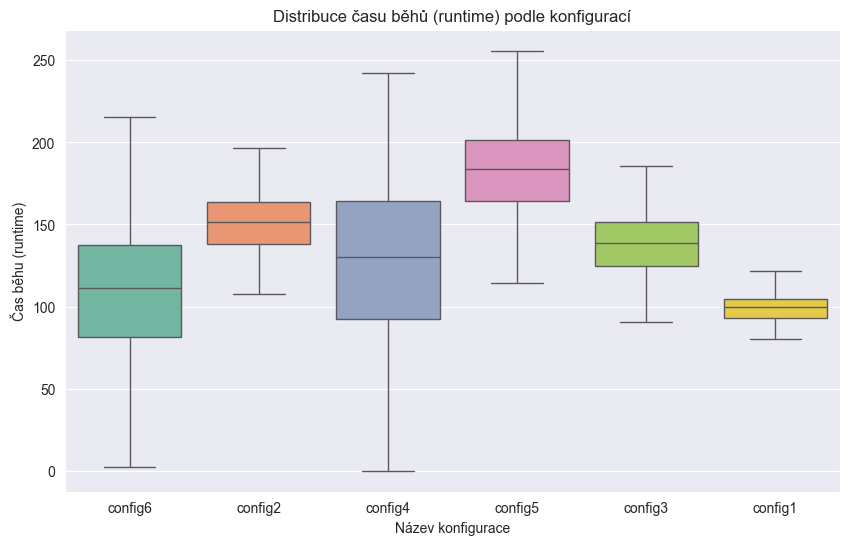

In [64]:
# Najdeme indexy všech outlierů
outliers = df.groupby("configuration", group_keys=False).apply(detect_outliers, include_groups=False)
outlier_indices = outliers.index

# Vytvoříme nový DataFrame bez outlierů
df = df.drop(index=outlier_indices)

# Vizualizace pomocí box plotu pro runtime podle konfigurací
plt.figure(figsize=(10, 6))
sns.boxplot(x="configuration", y="runtime", data=df, palette="Set2", hue="configuration")
plt.title("Distribuce času běhů (runtime) podle konfigurací")
plt.xlabel("Název konfigurace")
plt.ylabel("Čas běhu (runtime)")
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [65]:
dfstats = pd.DataFrame(df.groupby("configuration")["runtime"].describe())
dfstats

,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,190.0,99.449016,8.866788,80.124311,93.034540,99.799944,104.737728,121.904556
config2,195.0,151.688034,18.583050,107.522086,138.003905,151.516091,163.764042,196.293171
config3,194.0,138.292420,19.393682,90.567110,124.769359,138.448002,151.501348,185.413857
config4,198.0,126.317205,51.635948,0.000000,92.673117,129.887760,164.013094,241.987620
config5,196.0,184.049441,28.276656,114.035821,164.072975,183.916111,201.255548,255.807973
config6,199.0,110.422689,40.875754,2.124534,81.656211,111.043642,137.554141,215.295283


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._
1) Název konfigurace
2) Počet běhů dané konfigurace
3) Průměr času běhů dané konfigurace
4) Směrodatnou odchylku běhů dané konfigurace
5) Minimální hodnotu času běhu ze všech běhů dané konfiguraci
6) 25% (první kvartil, Q1) času běhu všech běhů dané konfigurace
7) 50% (druhý kvartil, Q2) času běhu všech běhů dané konfigurace neboli medián
8) 75% (první kvartil, Q1) času běhu všech běhů dané konfigurace
6) Maximální hodnotu času běhů ze všech běhů dané konfiguraci

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

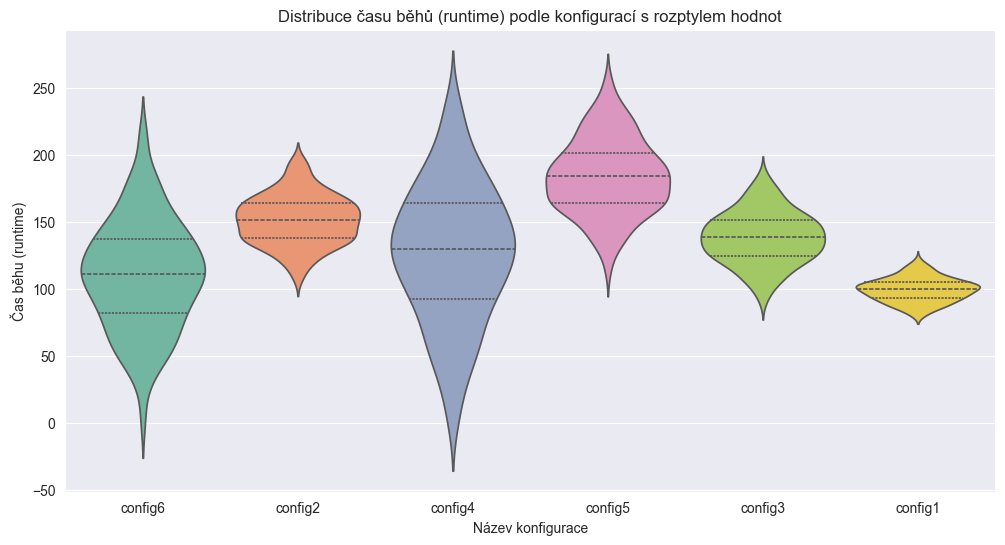

In [66]:
plt.figure(figsize=(12, 6))

# Použití palety barev a přiřazení hue k x-proměnné
sns.violinplot(x="configuration", y="runtime", data=df, inner="quartile", palette="Set2", hue="configuration", dodge=False, legend=False)

# Nastavení popisků a názvu grafu
plt.title("Distribuce času běhů (runtime) podle konfigurací s rozptylem hodnot")
plt.xlabel("Název konfigurace")
plt.ylabel("Čas běhu (runtime)")

# Zobrazení grafu
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

- Zvolil jsem houslový graf (violin plot) - oproti boxplots zobrazuje i hustotu dat, širší oblasti ukazují vyšší četnost hodnot, zatímco užší oblasti znamenají méně časté hodnoty.
- Pomocí inner="quartile" zobrazuji bílé vodorovné osy u každého houslového grafu, prostřední znázorňuje medián, vrchní znázorňuje hodnotu Q3 a spodní Q1.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

In [67]:
# TODO: Implementace s využitím knihovní funkcí


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [68]:
# TODO vlastni implementace zvoleneho testu